<a href="https://colab.research.google.com/github/Jihyun0510/nlp_hw/blob/main/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6 - Attention is All You Need

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/transformer1.png?raw=1)

## Introduction

Transformer는 convolutional seq-to-seq model과 마찬가지로 recurrence를 사용하지 않는다. 또한, convolutional layer을 사용하지 않고 linear layer, attention mechanism 그리고 normalization으로 구성되어 있다.


<!-- The most popular Transformer variant is [BERT](https://arxiv.org/abs/1810.04805) (**B**idirectional **E**ncoder **R**epresentations from **T**ransformers) and pre-trained versions of BERT are commonly used to replace the embedding layers - if not more - in NLP models. 

A common library used when dealing with pre-trained transformers is the [Transformers](https://huggingface.co/transformers/) library, see [here](https://huggingface.co/transformers/pretrained_models.html) for a list of all pre-trained models available.

The differences between the implementation in this notebook and the paper are:
- we use a learned positional encoding instead of a static one
- we use the standard Adam optimizer with a static learning rate instead of one with warm-up and cool-down steps
- we do not use label smoothing

We make all of these changes as they closely follow BERT's set-up and the majority of Transformer variants use a similar set-up. -->

## Preparing the Data



In [1]:
# 구버전 파이토치 패키지 설치
!pip install torch==1.8.0 torchtext==0.9.0
# !pip install torch==1.7.1 torchtext==0.8.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.5/735.5 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 56.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.8.0 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.8.0 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but 

In [2]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

Random seed를 고정하여 라이브러리들의 가중치 초기값이나 train/test set을 동일하게 split하는 등 작동 결과를 고정한다. 이를 통해서 실행 때마다 동일한 결과를 재현할 수 있다.

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


spaCy는 파이썬의 자연어처리를 위한 오픈 소스 기반 라이브러리이다. 


In [4]:
# spacy와 colab의 충돌로 인한 locale encoding 문제 해결
import locale
print(locale.getpreferredencoding())

ANSI_X3.4-1968


In [5]:
# spacy와 colab의 충돌로 인한 locale encoding 문제 해결
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [6]:
#영어, 독일어 spacy 모델을 다운로드
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
# 모델 불러오기
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

2023-04-11 02:22:35.889635: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2023-04-11 02:22:53.028555: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 16.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


spaCy의 기능 중 하나인 tocknizer을 각각 영어와 독일어에 대해서 만든다.

In [7]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

자연어 처리 라이브러리 토치텍스트(Torchtext)의 기능중 하나인 Field를 사용하여 필드를 통해 앞으로 어떤 전처리를 할 것인지를 정의한다. 

* tocknise = 어떤 토큰화 함수를 사용할 것인지 지정. (string.split이 기본값)
* lower = 영어 데이터를 전부 소문자화한다. (False가 기본값)
* batch_first = 미니 배치 차원을 맨 앞으로 하여 데이터를 불러올 것인지 여부. (False가 기본값)


In [8]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

Multi30k dataset을 로드하고 train, validation, test dataset으로  split한다.
또한 필드를 지정해줌으로써 미리 정의해 두었던 설정대로 데이터셋을 전처리 한다.


In [9]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 418kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 109kB/s] 


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 107kB/s] 


In [10]:
# 크기 확인
print('train 데이터의 크기 : {}' .format(len(train_data)))
print('test 데이터의 크기 : {}' .format(len(test_data)))

train 데이터의 크기 : 29000
test 데이터의 크기 : 1000


In [11]:
# train data 예시 확인
print("Source sentence:", vars(train_data[0])["src"])
print("Target sentence:", vars(train_data[0])["trg"])

Source sentence: ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']
Target sentence: ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


토큰화가 끝나고 단어 집합을 만들어주어야 한다. 정의한 필드에 .build_vocab()을 사용하여 단어 집합을 생성한다.


min_freq은 token이 vocabulary에 포함되기 위해 최소한으로 등장해야하는 횟수이다.

In [12]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [13]:
# vocab 확인, 사전형식으로 되어 있음을 확인할 수 있음
print(SRC.vocab.stoi)
# vocab의 크기 확인
print(len(SRC.vocab.stoi))

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f3e59a31790>>, {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3, '.': 4, 'ein': 5, 'einem': 6, 'in': 7, 'eine': 8, ',': 9, 'und': 10, 'mit': 11, 'auf': 12, 'mann': 13, 'einer': 14, 'der': 15, 'frau': 16, 'die': 17, 'zwei': 18, 'einen': 19, 'im': 20, 'an': 21, 'von': 22, 'sich': 23, 'dem': 24, 'mädchen': 25, 'junge': 26, 'vor': 27, 'zu': 28, 'steht': 29, 'männer': 30, 'sitzt': 31, 'hund': 32, 'den': 33, 'straße': 34, 'während': 35, 'gruppe': 36, 'hält': 37, 'spielt': 38, 'das': 39, 'hemd': 40, 'personen': 41, 'über': 42, 'drei': 43, 'eines': 44, 'frauen': 45, 'blauen': 46, 'neben': 47, 'ist': 48, 'kind': 49, 'roten': 50, 'weißen': 51, 'stehen': 52, 'sitzen': 53, 'menschen': 54, 'am': 55, 'aus': 56, 'spielen': 57, 'durch': 58, 'bei': 59, 'geht': 60, 'trägt': 61, 'fährt': 62, 'wasser': 63, 'um': 64, 'kinder': 65, 'kleines': 66, 'person': 67, 'macht': 68, 'springt': 69, 'kleiner': 70, 'schwarzen': 71, 

Finally, we define the device and the data iterator.

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

## Building the Model

transformer는 encoder와 decoder로 이루어져있다. 예시에서 Encoder는 독일어로 된 source sentence를 입력 받아 context vector로 encoding한다. 또한 Decoder는 영어로 된 target setence로 context vector를 decoding한다. 


### Encoder

Encoder는 전체 source sentence $X = (x_1, ... ,x_n)$를 하나의 고정된 vector $z$로 압축하는 대신 일련의 context vectors $Z = (z_1, ... , z_n)$를 생성한다. 예를 들어 source sentence가 5개의 token으로 이루어졌다면 encoder는 $Z = (z_1, z_2, z_3, z_4, z_5)$의 context vectors를 생성한다.

RNN의 hidden state at time $t$는 t시점과 그 이전의 모든 token들을 참고하지만 transformer의 context vector at time $t$는 입력 sequence의 모든 token를 참고하는 다른 점이 있다. 

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/transformer-encoder.png?raw=1)

위 그림과 같이 가장 먼저 입력 sequence의 token들이 standard embedding layer을 통과하여 embedding된다. Transformer는 recurrent 모델이 아니기 때문에 token의 순서에 대한 정보가 없다. 따라서 positional embedding layer을 추가하여 token의 position 정보를 입력 받아 embedding한다. 이때, 가장 첫번째 토근인 `<sos>`은 0 position으로 입력된다. 또한, vocabulary size를 설정하여 입력 토큰의 최대 길이를 지정할 수 있다. Standard embedding layer와 positional embedding layer을 통과한 결과물은 서로 합쳐진다. 따라서 결과 embedded vector은 토큰과 이의 위치 정보를 모두 포함하게 된다. 합쳐지기 전에 token embedding vectors는 scaling factor인 $\sqrt{d_{model}}$로 곱해지는데 $d_{model}$는 hidden dimension size이다. 이는 학습을 embedding의 variance를 줄여주어 학습을 용이하게 하도록 한다. 그 다음 합쳐진 embedding에 대하여 dropout이 적용된다. 


<!-- The original Transformer implementation from the Attention is All You Need paper does not learn positional embeddings. Instead it uses a fixed static embedding. Modern Transformer architectures, like BERT, use positional embeddings instead, hence we have decided to use them in these tutorials. Check out [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding) section to read more about the positional embeddings used in the original Transformer model. -->

합쳐진 embedding layer는 n개의 encoder layer을 통과하게 되고 그 결과물인 context vectors $Z$는 decoder에 입력된다. 


<!-- The source mask, `src_mask`, is simply the same shape as the source sentence but has a value of 1 when the token in the source sentence is not a `<pad>` token and 0 when it is a `<pad>` token. This is used in the encoder layers to mask the multi-head attention mechanisms, which are used to calculate and apply attention over the source sentence, so the model does not pay attention to `<pad>` tokens, which contain no useful information. -->

`Embedding layer`

임베딩 층은 입력 정수(vabcabulary)에 대해 밀집 벡터(dense vector)로 맵핑하고 이 밀집 벡터는 인공 신경망의 학습 과정에서 가중치가 학습되는 것과 같은 방식으로 훈련된다. 

이때 단어의 개수만큼 행을 가지는 matrix를 만들게 된다. 따라서 모든 단어는 고유한 임베딩 벡터를 가지게 된다. 특정 단어와 mapping되는 정수를 인덱스로 가지는 테이블로부터 임베딩 벡터 값을 가져오기 때문에 룩업 테이블이라고도 한다.

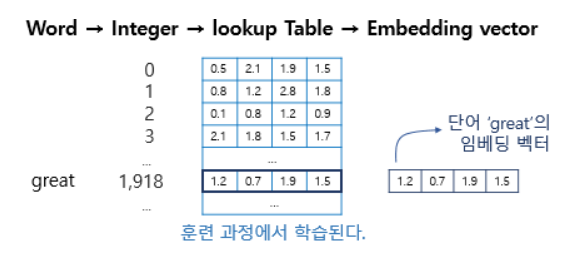

`nn.ModuleList`

 nn.ModuleList안에 Module들을 넣어 줌으로써 Module의 존재를 PyTorch에게 알려 준다. nn.ModuleList는 nn.Sequential과 마찬가지로 nn.Module의 list를 input으로 받는다. 이는 nn.Module을 저장하는 역할을 하지만 nn.Sequential과 다르게 forward() method가 없다. 두 종류의 module이 받는 input이 서로 다르고, 여러 개를 반복적으로 정의해야 할 때 유용하게 사용할 수 있다.

In [16]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        # tok_embedding은 input_dim의 입력 token을 받음, input_dim은 source의 vocabluary 크기와 동일
        # pos_embedding은 max_length만큼의 token sentence를 받을 수 있으며 sentence 내에서 token의 위치 정수를 받음
        # tok_embedding과 pos_embedding은 동일한 size를 output으로 함 (hidden dimension에 맞춤)
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        # n_layers 만큼 transformer block을 생성성
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len] embedding layer에 실제로 입력되는 batch size개의 문장
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0] # 몇 개의 source sentence가 한 batch로 동시에 들어오는지
        src_len = src.shape[1] # 입력 token sentence의 길이
        
        # 입력 token sentence 길이만큼 0부터 정수를 arange를 통해 생성함. 이 정수는 token의 위치 정보가 됨
        # 원래의 transfomer의 implementation과 다르게 여기서는 이 embedding layer을 학습함
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #pos_embedding(pos) = [batch size, src len, hid dim]
        #tok_embedding(src) = [batch size, src len, hid dim]
        #두 embedding의 크기가 동일하기 때문에 element-wise하게 값을 합칠 수 있음

        #결과물: src = [batch size, src len, hid dim] -> encoder에 들어가는 embedded 값이 됨
    
        #source mask를 사용하여 <pad>에 attention하지 못하도록 함 
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

### Encoder Layer

Transformer block

가장 처음으로 source sentence와 mask를 multi-head attention layer을 통과시킨다. 그 다음 attention에 dropout을 적용시킨다. 결과 값은 layer normalization layer에 입력되며 결과는 position-wise feedforward layer에 통과시킨다. 이번에도 결과값에 dropout을 적용시킨다. 


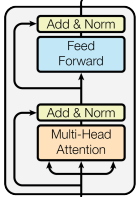

In [17]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim) # layer norm은 batch가 아닌 모든 example의 average를 계산하여 normalization을 함
        self.ff_layer_norm = nn.LayerNorm(hid_dim) 
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask) # 가장 첫번째 encoder layer의 경우 key, query, value의 값으로 source가 동일하게 입력됨. 
        # source mask = 만약 mask의 element가 0값을 가지면 minus infinity에 가깝게 작은 값으로 만들어서 영향이 없게 만듦. (softmax layer을 지날 때, 작은 값은 0에 가까운 value를 갖게 됨)
        
        #dropout, residual connection and layer norm
        # skip connection으로 multi-head attention layer을 통과하기 전 embedding과 통과한 후의 embedding이 합해진 후 normalization layer을 통과하게 된다. 
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        # positionwhise feedforward을 통과시킨 embedding과 통과시키기 이전의 embedding을 합한 후 normalization layer을 거치도록 함함
        src = self.ff_layer_norm(src + self.dropout(_src)) 
        
        #src = [batch size, src len, hid dim]
        
        return src

### Mutli Head Attention Layer


* Attention

Attention은 query, key, value로 계산된다. Query는 key를 사용하여 attention vector을 구하며, attention vector는 다시 values의 weighted sum을 구하는데 사용된다. (Attention vector는 softmax를 통하여 계산되기 때문에 0과 1사이의 값을 가지게 된다)

Transformer에서는 scaled dot-product attention을 사용하는데, qeury와 key가 dot product로 similarity score를 구하게 된다. 따라서 query와 key는 같은 size이어야 한다. 그 다음 scalining factor을 사용하여 값이 너무 커지는 것을 방지한다. 이렇게 구해진 값에 value를 곱하여 similarity score을 구한다. 

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

* Self-attention

Encoder와 decoder을 잇는 attention을 cross attention이라고 한다. Key와 value가 다른 sequence로 부터 생성되기 때문이다. 만약 key, value, query가 동일한 sequence로부터 생성이 되면 self-attention이라고 부른다. Attention은 output이 input에 attention을 두도록 하며, 반대로 self-attention은 input끼리 attention을 한다.


- Attention mechanism

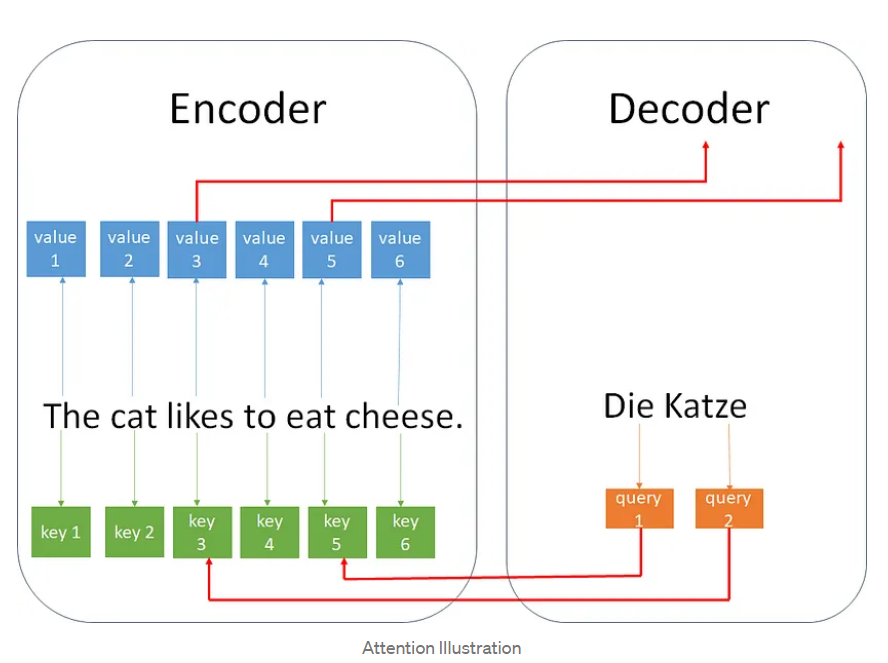

* self-attention

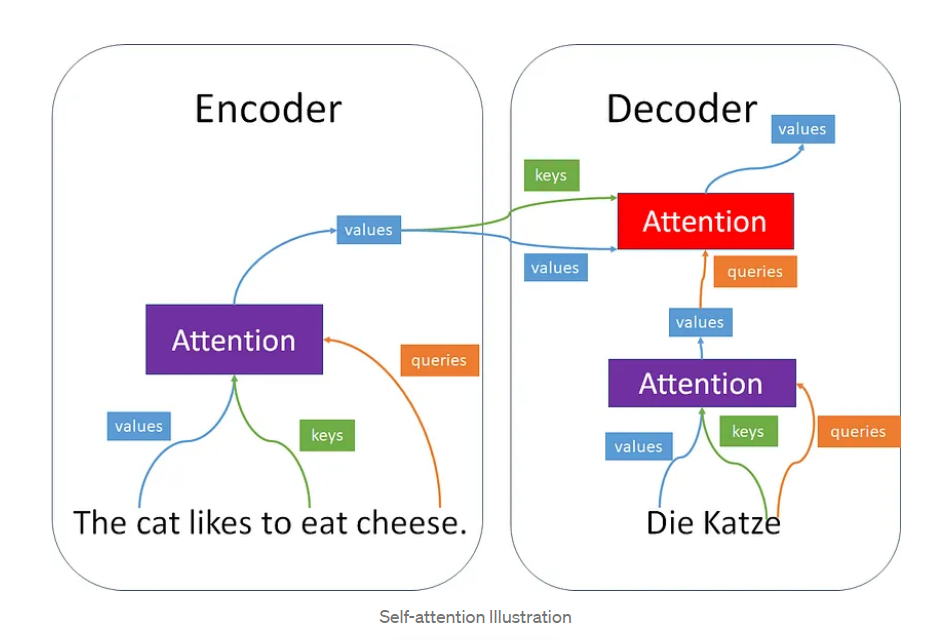

* Multihead attention

Multihead attention이 multihead라는 수식어가 붙은 이유는 n개의 head만큼 self-attention이 반복되기 때문이다 여기서 W는 학습되는 파라미터이다. 
따라서 embedding을 head의 개수만큼 split하여 scaled-dot-product가 모든 head에 대해서 병렬적으로 이루어지게 된다. 이를 통해서 여러 contcept에 attention을 둘 수 있다. 

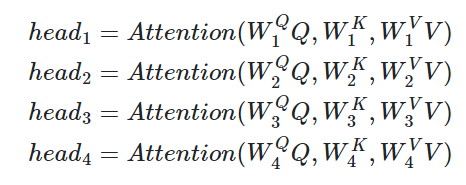

아래처럼 n개의 head는 합쳐져 다시 선형변환을 거치게 된다.

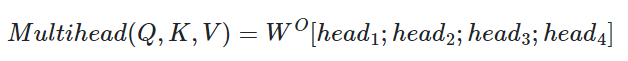

* Masked multi-haed attention



기존 sequecne 모델들은 순차적으로 값을 입력 받기 때문에 t+1 시점의 예측을 위해 사용할 수 있는 데이터가 t시점까지로 한정된다. 하지만 transformer는 전체 입력값을 한번에 입력 받기 때문에 과거 시점의 입력값을 예측할 때 미래 시점의 입력값까지 참고하여 cheating을 할 수 있는 문제가 있다. 이러한 문제를 해결하기 위해 미래 시점에 해당하는 값들의 weight들을 0(softmax를 통해)으로 만들어서 미래 시점의 입력값과 t까지의 입력값의 유사도를 구하지 못하도록 한다.

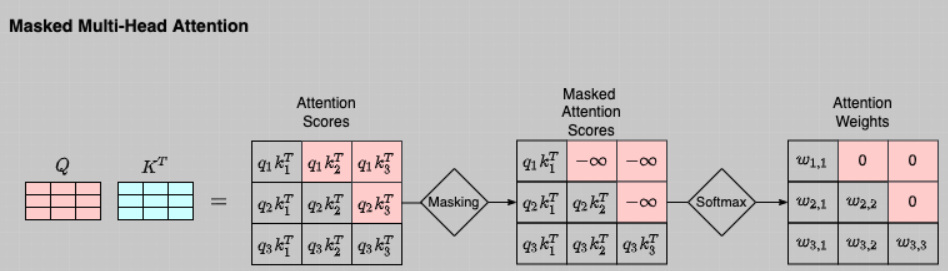

### Position-wise Feedforward Layer

Feed Forward의 목적은 알 수 없지만 부가적인 계산을 tasnformer block에 더한다. 가장 처음 linear layer을 통해서 forward expansion size로 embedding size를 변화시킨다. 그 다음 relu activation functino을 적용시킨 후 다시 처음의 embedding size로 linear layer을 거쳐 만든다. 

Transformer 논문에서는 embedding size 또는 hidden dimention을 512, 그리고 feedforward expansion size를 2048로 설정하였다. 더불어 hidden dimension으로 mapping되기 전의 값에 대하여 dropout이 적용된다. 

In [18]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### Decoder


In [19]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [50]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads # 논문: Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions.
        self.head_dim = hid_dim // n_heads # embedding을 n개의 head로 split함. 따라서 embedding size는 head의 개수로 나누어질 수 있어야 함. 
        
        self.fc_q = nn.Linear(hid_dim, hid_dim) 
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim) 
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None): # 입력되는 source가 동일하게 각각 쿼리, 키, 벨류로 입력됨
        
        batch_size = query.shape[0] # 한번에 처리하는 sentence의 개수

        #query = [batch size, query len, hid dim] (target setence)
        #key = [batch size, key len, hid dim] (source sentence)
        #value = [batch size, value len, hid dim]
        
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!Q", query.shape)
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mask", mask.shape)
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]

        # embedding을 n개의 head로 split함        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3) # 여기서 -1은 query length에 해당함
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3) # 여기서 -1은 key length에 해당함
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3) # 여기서 -1은 value length에 해당함
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale #cacluate energy (the un-normalized attention) by multiplying Q and K together and scaling it by the square root of head_dim
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None: 
            energy = energy.masked_fill(mask == 0, -1e10) # masked_fill을 사용해서 mask에서 값이 0인 것들에 위치가 매칭되는 energy의 값을 -1e10로 바꿔줌
        
        attention = torch.softmax(energy, dim = -1) # key len (source sentence)을 기준으로 attention score을 1로 normalize함
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V) # attention과 value를 행렬곱함
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim) # split 되었던 head를 합침으로써 split 이전 크기와 동일해짐
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x) 
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Decoder Layer

Encoder layer와 다르게 decoder layer는 2개의 multi-head attention을 가지고 있다. Masked multi-head attention이 추가됐다는 차이점이 있지만 그 이후로는 encoder layer와 유사한다. 

가장 처음의 encoder layer와 유사하게 target source가 key, query, value로 입력된다. Attention 값은 dropout을 거친 후 skip connection의 값과 합쳐져 layer normalization을 통과하게 된다. 앞서 설명한 대로 masked multi-head attention에서는 target mask가 사용되어 앞으로 예측할 입력 source를 예측에 사용하지 못하도록 한다. transformer가 target sentence의 모든 token을 병렬처리하기 떄문에 필요한 조치이다. 

Masked multi-head attention 이후에 encoder의 source sentence를 decoder에 입혁하기 위하여 encoder의 key와 value가 이전 masked-multi head attention의 결과값을 query로 사용한다. 앞서 설명했는이 source mask는 <pad> token에 attention하지 않도록 사용된다. 그 다음 encoder와 마찬가지로 attention 값에 dropout이 적용되고 이전 attention layer에서 skip connection으로 받은 값과 2번째 attention layer로 받은 값과 합하여 normalization을 하게 된다. 

마지막으로 feedforward layer에 skip connection으로 받은 값과 이전 attention layer에서 받은 값을 통과시켜 마찬가지고 drop out과 normalization을 하게 된다. 

In [21]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask) # 가장 처음의 attention layer에는 source sentence의 key, value, query과 함께 target mask가 입력됨
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg)) 
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)# 그 다음의 attention layer에서는 encoder의 값이 key와 value로 입력되도 decoder의 attention 값이 query로 입력되게 됨, 여기서는 encoder의 attention layer의 구조를 사용함
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention  

### Seq2Seq

마지막으로 `Seq2Seq` 모듈은 앞서 생성한 encoder와 decoder를 합치며 mask를 생성하는 역할을 수행한다.

Source mask는 soure sequence에서 `<pad>` 토큰이 아닌 토큰을 찾아 mask의 값을 1로 설정하고 아닐 경우 값을 0으로 설정한다 Energy와 동일한 shape을 갖기 위하여 unsqueezed 되어 (N, 1, 1, source length)로 mask의 shape을 설정한다. Energy의 shape은 [batch size, n heads, seq len, seq len] 와 같다. 

Tarket mask는 source mask와 만들었던 동일한 방식으로 pad 토큰으로 mask를 만든다. 그 다음 diogonal mask를 생성한다. 이는 diagonal 이상의 값을 0로 만들며, 그 아래의 값은 원래의 1의 값을 취하게 만들어 target mask를 생성한다. 
(for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

subsequence mask

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$


그 source mask와 tarket mask를 정의한 후 앞서 생성한 encoder와 decoder를 사용하여 target sentence를 예측하게 된다. 

In [52]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool() # diagonal matrix 생성성
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Training the Seq2Seq Model


In [23]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [24]:
print("input_dimension:{}".format(INPUT_DIM))
print("output_dimension:{}".format(OUTPUT_DIM))

input_dimension:7853
output_dimension:5893


In [25]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

생성된 Transformer의 파라미터 개수는 convolutional seq-to-seq model의 파라미터 개수였던 37 millin 보다 월등히 적다.

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


Xavier uniform을 사용하여 weight initilization을 진행한다.


In [27]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [28]:
model.apply(initialize_weights);

In [29]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

Loss function을 정의하며 ignore_index를 사용하여 `<pad>` 토큰에 해당하는 값들에 대한 loss를 계산하지 않도록 한다.

In [30]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

<!-- Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial. -->

trianing loop을 정의한다. 

`<eos>`을 예측하지만 모델의 gt target 입력으로는 받지 않기 위해서 `<eos>`를 slicing을 통해서 잘라낸다:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$는 실질적은 target 문장 요소를 나타낸다. (sos와 eos 토큰이 개수에서 제외되어 있다) 이는 모델에 입력되어 eos 토큰이 포함된 target 문장을 예측한다: 

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$은 예측된 target 문장의 요소를 나타낸다. loss는 gt 입력 target 문장의 sos를 제외하고 계산된다. 하지만 eos는 포함하여 계산한다. 
<!-- $y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token: -->

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

<!-- We then calculate our losses and update our parameters as is standard. -->

In [42]:
OUTPUT_DIM

5893

In [ ]:
# for i, batch in enumerate(train_iterator):
#   print(batch.trg[batch.trg >= OUTPUT_DIM])

In [31]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Evaluation loop은 training 코드와 gradient 계산과 파라미터 업데이트가 포함되지 않은 것을 제외하면 동일하다. 

In [32]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

한 epoch에 소요되는 시간을 측정하기 위한 코드를 정의한다. 

In [33]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

모델을 학습시킨다. 


In [53]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

RuntimeError: ignored

We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [ ]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

FileNotFoundError: ignored

## Inference

Now we can can translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- create the source sentence mask
- feed the source sentence and mask into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - create a target sentence mask
  - place the current output, encoder output and both masks into the decoder
  - get next output token prediction from decoder along with attention
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

First, we'll get an example from the training set.

In [ ]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


Our translation looks pretty good, although our model changes *is walking by* to *walks by*. The meaning is still the same.

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

RuntimeError: ignored

We can see the attention from each head below. Each is certainly different, but it's difficult (perhaps impossible) to reason about what head has actually learned to pay attention to. Some heads pay full attention to "eine" when translating "a", some don't at all, and some do a little. They all seem to follow the similar "downward staircase" pattern and the attention when outputting the last two tokens is equally spread over the final two tokens in the input sentence.

In [ ]:
display_attention(src, translation, attention)

NameError: ignored

Next, let's get an example the model has not been trained on from the validation set.

In [ ]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


The model translates it by switching *is running* to just *runs*, but it is an acceptable swap.

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'runs', 'after', 'the', 'black', 'dog', '.', '<eos>']


Again, some heads pay full attention to "ein" whilst some pay no attention to it. Again, most of the heads seem to spread their attention over both the period and `<eos>` tokens in the source sentence when outputting the period and `<eos>` sentence in the predicted target sentence, though some seem to pay attention to tokens from near the start of the sentence.

<ipython-input-30-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-30-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


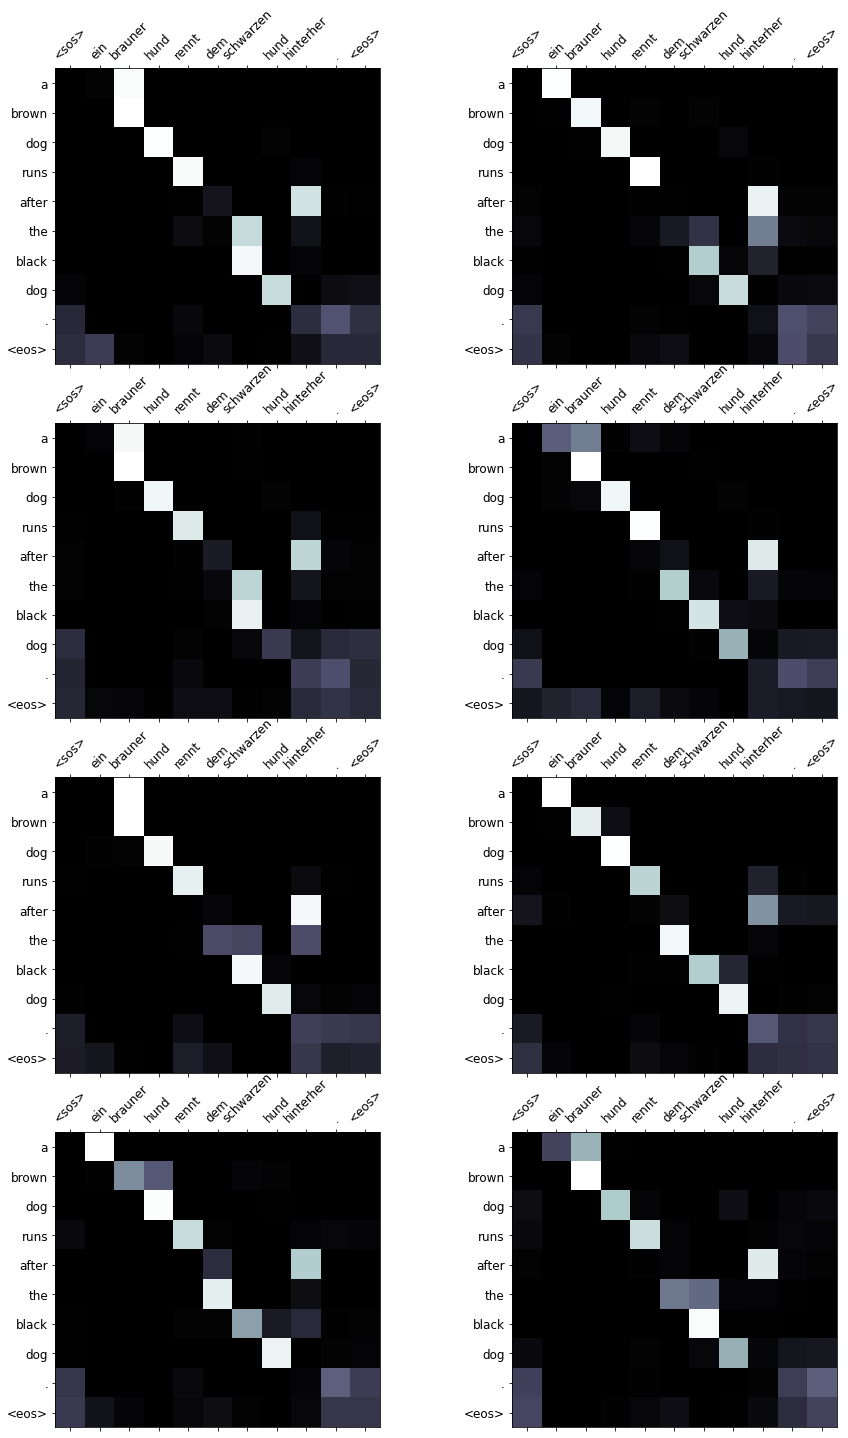

In [ ]:
display_attention(src, translation, attention)

Finally, we'll look at an example from the test data.

In [ ]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


A perfect translation!

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'mother', 'and', 'her', 'young', 'son', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.', '<eos>']


<ipython-input-30-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-30-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


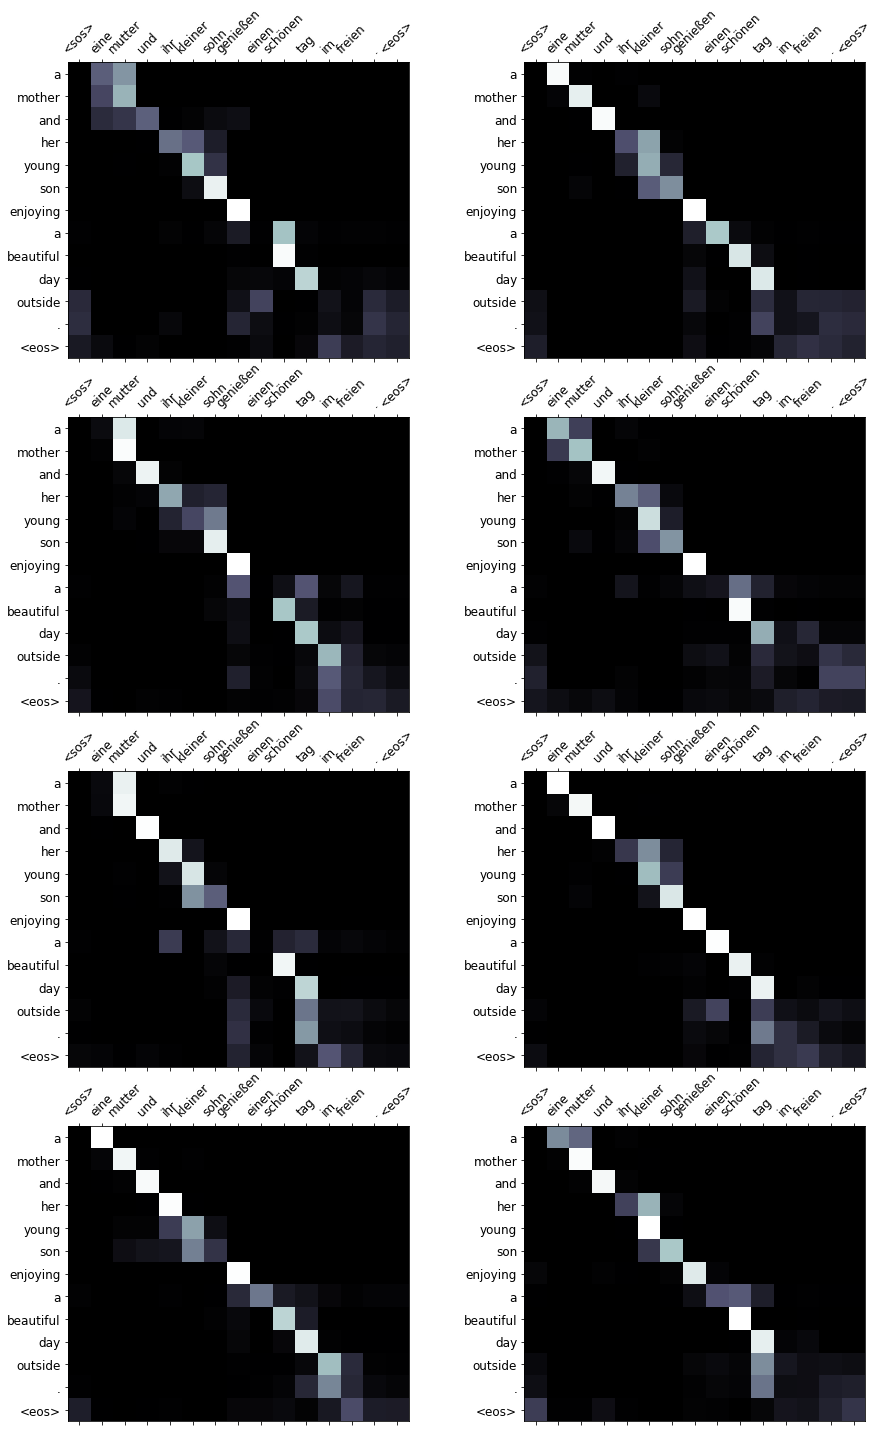

In [ ]:
display_attention(src, translation, attention)

## BLEU

Finally we calculate the BLEU score for the Transformer.

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

We get a BLEU score of 36.52, which beats the ~34 of the convolutional sequence-to-sequence model and ~28 of the attention based RNN model. All this whilst having the least amount of parameters and the fastest training time!

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 36.52


Congratulations for finishing these tutorials! I hope you've found them useful.

If you find any mistakes or want to ask any questions about any of the code or explanations used, feel free to submit a GitHub issue and I will try to correct it ASAP.

## Appendix

The `calculate_bleu` function above is unoptimized. Below is a significantly faster, vectorized version of it that should be used if needed. Credit for the implementation goes to [@azadyasar](https://github.com/azadyasar).

In [ ]:
def translate_sentence_vectorized(src_tensor, src_field, trg_field, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu_alt(iterator, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for batch in iterator:
            src = batch.src
            trg = batch.trg
            _trgs = []
            for sentence in trg:
                tmp = []
                # Start from the first token which skips the <start> token
                for i in sentence[1:]:
                    # Targets are padded. So stop appending as soon as a padding or eos token is encountered
                    if i == trg_field.vocab.stoi[trg_field.eos_token] or i == trg_field.vocab.stoi[trg_field.pad_token]:
                        break
                    tmp.append(trg_field.vocab.itos[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, src_field, trg_field, model, device)
            pred_trgs += pred_trg
    return pred_trgs, trgs, bleu_score(pred_trgs, trgs)